
# Importações

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random
import cudf as pd
import tensorflow as tf

from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from pyESN import ESN
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error as mape
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


def rrmse(actual, predicted) -> int:
    return root_mean_squared_error(actual, predicted) / np.mean(actual)


def smape(actual, predicted) -> int:
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return round(
        np.mean(
            np.abs(predicted - actual) /
            ((np.abs(predicted) + np.abs(actual)) / 2)
        ), 5
    )


reset_seed()
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/path/to/cuda'

2025-02-16 18:40:37.956001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 18:40:37.973051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 18:40:37.978337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 18:40:37.991569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eduardo/miniconda3/envs/rapid

# Carregar Datasets

In [2]:
df_mesclado = pandas.read_csv("./dados/dados_mesclados.csv", sep=';', decimal='.')
df_features = pandas.read_csv("./dados/fitness_features_agrupado.csv", sep=";", decimal=".")

df_features = df_features.sort_values("MAPE").head(1).reset_index(drop=True)
df_features = pandas.DataFrame(
    columns=str(df_features.iloc[0]["FEATURES"]).replace("(", '').replace(")", '').replace("'", "").split(", "))

df_features = df_features.drop(df_features.filter(like='CAMPUS_').columns, axis=1)
df_features

Empty DataFrame
Columns: [LAG_01, LAG_12, LAG_06, LAG_05, LAG_11, LAG_02, COVID, LAG_03, FÉRIAS, MÊS_mar, ANO_2021, ANO_2022, ANO_2023, ANO_2024, ANO_2015, ANO_2016, ANO_2017, ANO_2018, ANO_2019, ANO_2020, ANO_2014, TEMP_MÉD_MÉD_MENS, PRECIPITAÇÃO_MAX_MENS, MÊS_fev, TEMP_MÉD_MAX_MENS, LAG_07, LAG_08, TEMP_MIN_ACC_MENS, TEMP_MIN_MAX_MENS, TEMP_MÉD_ACC_MENS, DIA_DA_SEMANA_dom, LAG_09, CURSOS_GRAD_MATUTINO, TEMP_MAX_MAX_MENS, CURSOS_POS, MÊS_dez, TEMP_MAX_ACC_MENS, TEMP_MIN_MIN_MENS, CURSOS_GRAD_VESPERTINO, FERIADO, DIA_DA_SEMANA_sex, CURSOS_TEC_INTEGRADO, LAG_10]
Index: []

[0 rows x 43 columns]

# Melhores Parâmetros

In [3]:
best = {}
for modelo in ["ESN", "LSTM", "RF", "XGB"]:
    df_aux = pandas.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed in ["10000", "20000", "30000"]:
            new_df = pandas.read_csv(f'parâmetros/{optimizer}-{modelo} ITERS SEED {seed}.csv', sep=";", decimal=".",
                                     header=0)
            df_aux = pandas.concat([df_aux, new_df], axis=0)

    df_aux = df_aux.sort_values(by=["Fitness"])
    df_aux[df_aux.isnull()] = None
    best[f"{modelo}"] = df_aux[:1].iloc[0].to_dict()

# Criação dos Modelos

In [4]:
def get_modelo(nome):
    if nome == "ESN":
        return ESN(n_inputs=df_features.columns.shape[0],
                   n_outputs=1,
                   n_reservoir=int(best["ESN"]["Reservoirs"]),
                   sparsity=best["ESN"]["Sparsity"],
                   spectral_radius=best["ESN"]["Spectral Radius"],
                   noise=best["ESN"]["Noise"],
                   random_state=SEED)

    if nome == "LSTM":
        tf.keras.backend.clear_session()
        lstm = Sequential([
            Input((df_features.columns.shape[0], 1)),
            LSTM(best["LSTM"]["Units"],
                 activation=best["LSTM"]["Activation"],
                 use_bias=best["LSTM"]["Bias"],
                 seed=SEED),
            Dense(1),
        ])
        lstm.compile(loss='mape')
        return lstm

    if nome == "RF":
        return RandomForest(random_state=SEED,
                            n_estimators=int(best["RF"]["N_estimators"]),
                            max_depth=int(best["RF"]["Max_depth"]),
                            min_samples_split=int(best["RF"]["Min_samples_split"]),
                            min_samples_leaf=int(best["RF"]["Min_samples_leaf"]))

    if nome == "XGB":
        updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
        return XGBRegressor(random_state=SEED,
                            n_estimators=int(best["XGB"]["N_estimators"]),
                            max_depth=int(best["XGB"]["Max_depth"]),
                            booster=best["XGB"]["Booster"],
                            reg_lambda=best["XGB"]["Lambda"],
                            reg_alpha=best["XGB"]["Alpha"],
                            updater=updater)


# Treino e Teste
## Divisão dos Dados

In [5]:
# modelos = ["ESN", "LSTM", "RF", "XGB"]
modelos = ["ESN"]
horizonte = 1

colunas = [item for item in df_features if 'LAG_' not in item]
colunas = df_mesclado.drop(np.append(df_mesclado.drop(colunas, axis=1).columns.to_list(), ['DATA', 'CAMPUS', 'REGIÃO', 'ORDEM']), axis=1).columns
colunas = np.append('CONSUMO', colunas)

dataframes_treino = []
dataframes_teste = []
scalers = {}

for campus, dados in df_mesclado.groupby("CAMPUS"):
    scaler = MinMaxScaler()
    dados["CAMPUS"] = campus
    dados[colunas] = scaler.fit_transform(dados[colunas]).copy()

    for i in range(1, 12 + 1):
        lag = dados['CONSUMO'].shift(i)
        dados[f'LAG_' + '{:02d}'.format(i)] = lag
    dados.dropna(inplace=True)

    treino, teste = train_test_split(dados, test_size=12, random_state=SEED, shuffle=False)

    dataframes_treino.append(treino)
    dataframes_teste.append(teste)
    scalers[campus] = scaler

df_treino = pd.DataFrame(pandas.concat(dataframes_treino, ignore_index=True).sort_values("CAMPUS").sort_values("DATA"))
df_teste = pd.DataFrame(pandas.concat(dataframes_teste, ignore_index=True).sort_values("CAMPUS").sort_values("DATA"))
features = df_treino.drop(df_treino.drop(df_features, axis=1).columns.to_list(), axis=1).columns

df_treino.to_pandas()

CONSUMO        DATA  TEMP_MIN_MÉD_MENS  TEMP_MÉD_MIN_MENS  \
1269  0.383913  2015-01-31               19.0               22.0   
1270  0.658598  2015-02-28               19.0               21.0   
1375  0.325532  2015-02-28               20.0               23.0   
1271  0.914417  2015-03-31               18.0               21.0   
1376  0.581936  2015-03-31               18.0               23.0   
...        ...         ...                ...                ...   
1743  0.817150  2023-10-31               13.0               17.0   
166   0.701569  2023-10-31               17.0               21.0   
1561  0.672674  2023-10-31               11.0               12.0   
1622  0.568785  2023-10-31               13.0               18.0   
1888  0.560042  2023-10-31               10.0               13.0   

      TEMP_MÉD_MÉD_MENS  TEMP_MÉD_MAX_MENS  TEMP_MÉD_ACC_MENS  \
1269           0.923077           0.928571           0.907583   
1270           0.846154           0.857143           0.644550   
1375           0.727273           0.571429           0.552846   
1271           0.769231           0.642857           0.729858   
1376           0.636364           0.500000           0.704607   
...                 ...                ...                ...   
1743           0.727273           0.800000           0.688022   
166            0.800000           0.800000           0.757669   
1561           0.538462           0.692308           0.547912   
1622           0.666667           0.600000           0.702186   
1888           0.615385           0.600000           0.591241   

      TEMP_MAX_MÉD_MENS  PRECIPITAÇÃO_MÉD_MENS  TEMP_MIN_MIN_MENS  ...  \
1269               36.0                    9.0           0.888889  ...   
1270               35.0                   13.0           0.888889  ...   
1375               33.0                    6.0           0.925926  ...   
1271               30.0                    6.0           0.833333  ...   
1376               33.0                    2.0           0.851852  ...   
...                 ...                    ...                ...  ...   
1743               33.0                   15.0           0.827586  ...   
166                36.0                   11.0           0.862069  ...   
1561               32.0                   14.0           0.806452  ...   
1622               33.0                   19.0           0.791667  ...   
1888               30.0                   18.0           0.700000  ...   

        LAG_03    LAG_04    LAG_05    LAG_06    LAG_07    LAG_08    LAG_09  \
1269  0.608103  0.514901  0.472503  0.347222  0.427041  0.574027  0.594242   
1270  0.722672  0.608103  0.514901  0.472503  0.347222  0.427041  0.574027   
1375  0.442819  0.348337  0.312779  0.269720  0.180601  0.146244  0.227111   
1271  0.575405  0.722672  0.608103  0.514901  0.472503  0.347222  0.427041   
1376  0.335771  0.442819  0.348337  0.312779  0.269720  0.180601  0.146244   
...        ...       ...       ...       ...       ...       ...       ...   
1743  0.418226  0.591132  0.683025  0.674953  1.000000  0.448175  0.291355   
166   0.251238  0.414419  0.473445  0.486791  0.800083  0.500413  0.178316   
1561  0.486392  0.779147  0.776940  0.649136  0.828430  0.563075  0.315373   
1622  0.372455  0.721160  0.562153  0.367983  0.702036  0.483189  0.287940   
1888  0.551563  0.744462  0.732697  0.610387  0.751775  0.554213  0.372125   

        LAG_10    LAG_11    LAG_12  
1269  0.792566  0.721154  0.435673  
1270  0.594242  0.792566  0.721154  
1375  0.290049  0.325269  0.349124  
1271  0.574027  0.594242  0.792566  
1376  0.227111  0.290049  0.325269  
...        ...       ...       ...  
1743  0.489881  0.519712  0.552293  
166   0.291552  0.367089  0.375206  
1561  0.488047  0.698786  0.762229  
1622  0.492906  0.496453  0.480259  
1888  0.617806  0.633810  0.583784  

[1889 rows x 101 columns]

## Definição das Funções

In [6]:
def treino_kfold_regr(modelo, dataframe, features):
    scores = pandas.DataFrame(columns=["MAPE", "sMAPE"])
    subdf = {data: dados for data, dados in dataframe.sort_values("CAMPUS", ascending=True).groupby('DATA')}
    for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
        i_treino = [list(subdf.keys())[index] for index in i_treino]
        i_teste = [list(subdf.keys())[index] for index in i_teste]

        dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
        dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)

        x_treino, y_treino = dados_treino[features].astype(np.float32).to_cupy().get(), dados_treino[
            "CONSUMO"].astype(
            np.float32).to_cupy().get()
        x_teste, y_teste = dados_teste[features].astype(np.float32).to_cupy().get(), dados_teste[
            "CONSUMO"].to_cupy().get()

        y_previsto = []
        if isinstance(modelo, RandomForest) or isinstance(modelo, XGBRegressor):
            modelo.fit(x_treino, y_treino)
            for row in x_teste:
                previsao = modelo.predict(row.reshape(1, -1))
                y_previsto.append(previsao)

        else:
            if isinstance(modelo, ESN):
                modelo.fit(x_treino, y_treino)
            else:
                modelo.fit(x_treino, y_treino, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
                           batch_size=best["LSTM"]["Batch Size"])
            for row in x_teste:
                previsao = modelo.predict(row.reshape(1, -1))[0]
                y_previsto.append(previsao)

        medidas = pandas.DataFrame([[mape(y_teste, y_previsto), smape(y_teste, y_previsto)]],
                                   columns=["MAPE", "sMAPE"]).round(5)
        scores = pandas.concat([scores, medidas])

    return scores


def treino_split_regr(modelo, dataframe_treino, features):
    x_treino = dataframe_treino[features].astype(np.float32).to_cupy().get()
    y_treino = dataframe_treino["CONSUMO"].astype(np.float32).to_cupy().get()

    if isinstance(modelo, RandomForest) or isinstance(modelo, XGBRegressor):
        modelo.fit(x_treino, y_treino)
    else:
        if isinstance(modelo, ESN):
            modelo.fit(x_treino, y_treino)
        else:
            modelo.fit(x_treino, y_treino, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
                       batch_size=best["LSTM"]["Batch Size"])
    return modelo


def teste_split_regr(modelo, dataframe_treino, dataframe_teste, features, horizonte):
    dataframe_treino = dataframe_treino.sort_values("DATA")
    dataframe_teste = dataframe_teste.sort_values("DATA")

    dataframe_treino = dataframe_treino.set_index("DATA")
    dataframe_teste = dataframe_teste.set_index("DATA")

    xy_teste = dataframe_teste[np.append(features, "CONSUMO")].astype(np.float32)[:horizonte]
    y_teste = dataframe_teste["CONSUMO"].astype(np.float32)[:horizonte].to_cupy().get()

    dataframe_conjunto = dataframe_treino[np.append(features, "CONSUMO")].copy().astype(np.float32)

    preds = []

    for i_test in range(horizonte):
        row = xy_teste.iloc[[i_test]].copy()

        dataframe_conjunto = pd.concat([dataframe_conjunto, row], axis=0)

        for lag in range(1, 12 + 1):
            if 'LAG_' + "{:02d}".format(lag) in xy_teste.columns:
                row[f'LAG_' + '{:02d}'.format(lag)] = dataframe_conjunto["CONSUMO"].shift(lag)
                dataframe_conjunto[f'LAG_' + '{:02d}'.format(lag)] = dataframe_conjunto["CONSUMO"].shift(lag)

        if isinstance(modelo, RandomForest) or isinstance(modelo, XGBRegressor):
            pred = modelo.predict(row[features].to_cupy().get().reshape(1, -1))
        else:
            pred = modelo.predict(row[features].to_cupy().get().reshape(1, -1))[0]

        row["CONSUMO"] = pred
        preds.append(pred)
        dataframe_conjunto.update(row)

    medidas = pandas.Series([mape(y_teste, preds), smape(y_teste, preds)], index=["MAPE", "sMAPE"]).round(5)

    return medidas, dataframe_conjunto

## Treino com todos os campi

In [7]:
medidas_todos = pandas.DataFrame()
dataframes_todos = {}
scores_todos = {}

for nome_modelo in modelos:

    for campus, dados_teste in df_teste.groupby("CAMPUS"):
        modelo = treino_split_regr(get_modelo(nome_modelo), df_treino, features)

        # # TODO ativar para rodar com kfold
        # score = treino_kfold_regr(modelo, dados_treino, features)
        # scores_todos[(campus, modelo)] = score

        dados_treino = df_treino[df_treino["CAMPUS"] == campus]
        medida, df = teste_split_regr(modelo, dados_treino, dados_teste, features, horizonte)
        dataframes_todos[(campus, nome_modelo)] = df

        medidas_todos = pandas.concat([medidas_todos, pandas.DataFrame([[campus, medida["MAPE"], medida["sMAPE"]]],
                                                                       columns=["CAMPUS", f"MAPE {nome_modelo}",
                                                                                f"sMAPE {nome_modelo}"])])

    medidas_todos = pandas.concat(
        [medidas_todos, pandas.DataFrame(
            [["TOTAL", medidas_todos[f"MAPE {nome_modelo}"].mean(), medidas_todos[f"sMAPE {nome_modelo}"].mean()]],
            columns=["CAMPUS", f"MAPE {nome_modelo}", f"sMAPE {nome_modelo}"])]).round(5)
medidas_todos

CAMPUS  MAPE ESN  sMAPE ESN
0            ARAPONGAS   0.53327    0.42101
0  ASSIS CHATEAUBRIAND   0.00485    0.00486
0              ASTORGA   0.01694    0.01709
0             BARRACÃO   0.11033    0.11677
0          CAMPO LARGO   0.01458    0.01447
0             CAPANEMA   0.27926    0.24504
0             CASCAVEL   0.05447    0.05600
0              COLOMBO   0.08763    0.09165
0       CORONEL VIVIDA   1.48873    0.85345
0             CURITIBA   0.06214    0.06413
0        FOZ DO IGUAÇU   0.03727    0.03659
0              GOIOERÊ   0.01038    0.01033
0                IRATI   0.06150    0.06345
0             IVAIPORÃ   0.10790    0.11405
0          JACAREZINHO   0.31676    0.37637
0          JAGUARIAÍVA   0.10930    0.11562
0    LONDRINA - CENTRO   0.00303    0.00303
0     LONDRINA - NORTE   0.24120    0.21524
0               PALMAS   0.31487    0.27204
0            PARANAGUÁ   0.26062    0.29968
0            PARANAVAÍ   0.13517    0.14497
0              PINHAIS   0.12889    0.12109
0              PITANGA   0.11226    0.11893
0     QUEDAS DO IGUAÇU   0.40703    0.33820
0       TELÊMACO BORBA   0.09142    0.09580
0             UMUARAMA   0.14979    0.16192
0     UNIÃO DA VITÓRIA   0.17504    0.19183
0                TOTAL   0.19684    0.16902



## Treino com campi individuais

In [8]:

medidas_ind = pandas.DataFrame()
dataframes_ind = {}
scores_ind = {}

for nome_modelo in modelos:

    for campus, dados_teste in df_teste.groupby("CAMPUS"):
        dados_treino = df_treino[df_treino["CAMPUS"] == campus]

        modelo = treino_split_regr(get_modelo(nome_modelo), dados_treino, features)
        # # TODO ativar para rodar com kfold
        # score = treino_kfold_regr(modelo, dados_treino, features)
        # scores_ind[(campus, modelo)] = score

        medida, df = teste_split_regr(modelo, dados_treino, dados_teste, features, horizonte)
        dataframes_ind[(campus, nome_modelo)] = df

        medidas_ind = pandas.concat([medidas_ind, pandas.DataFrame([[campus, medida["MAPE"], medida["sMAPE"]]],
                                                                   columns=["CAMPUS", f"MAPE {nome_modelo}",
                                                                            f"sMAPE {nome_modelo}"])])

    medidas_ind = pandas.concat(
        [medidas_ind, pandas.DataFrame(
            [["TOTAL", medidas_ind[f"MAPE {nome_modelo}"].mean(), medidas_ind[f"sMAPE {nome_modelo}"].mean()]],
            columns=["CAMPUS", f"MAPE {nome_modelo}", f"sMAPE {nome_modelo}"])]).round(5)
medidas_ind

CAMPUS  MAPE ESN  sMAPE ESN
0            ARAPONGAS   0.17699    0.16260
0  ASSIS CHATEAUBRIAND   0.18196    0.16679
0              ASTORGA   0.12270    0.13072
0             BARRACÃO   0.35596    0.43303
0          CAMPO LARGO   0.01790    0.01806
0             CAPANEMA   0.04311    0.04405
0             CASCAVEL   0.01910    0.01892
0              COLOMBO   0.06584    0.06808
0       CORONEL VIVIDA   1.01791    0.67458
0             CURITIBA   0.43120    0.54972
0        FOZ DO IGUAÇU   0.60339    0.46354
0              GOIOERÊ   0.43080    0.54906
0                IRATI   0.05115    0.05249
0             IVAIPORÃ   0.36441    0.44560
0          JACAREZINHO   0.18569    0.20469
0          JAGUARIAÍVA   0.06726    0.06507
0    LONDRINA - CENTRO   0.06699    0.06482
0     LONDRINA - NORTE   0.17347    0.15962
0               PALMAS   0.70917    0.52353
0            PARANAGUÁ   0.42789    0.54435
0            PARANAVAÍ   0.21575    0.24183
0              PINHAIS   0.12809    0.12038
0              PITANGA   0.32629    0.38990
0     QUEDAS DO IGUAÇU   0.40370    0.33590
0       TELÊMACO BORBA   0.15626    0.16950
0             UMUARAMA   0.43828    0.56128
0     UNIÃO DA VITÓRIA   0.13970    0.15019
0                TOTAL   0.27115    0.27068

# Gráficos
## Definição dos Gráficos

In [9]:
def ts_comparacao(campus, valor_real, valores_previstos):
    valor_real = valor_real.tail(12)

    plt.figure(figsize=(12, 4.5))
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=["blue", "green", "darkgoldenrod", colors.red_rgb, "purple", "cyan", "slategrey", "coral"])

    for modelo, previsao in valores_previstos.items():
        previsao = previsao.tail(12)
        plt.plot(previsao.index, previsao["CONSUMO"], label=f"{modelo} - {campus}")

    plt.plot(valor_real.index, valor_real["CONSUMO"], label=f"CONSUMO REAL - {campus}")

    plt.xlabel('Mês')
    plt.ylabel('Consumo (KWh)')

    ax = plt.gca()
    ax.set_facecolor('white')

    plt.xticks(valor_real.index, valor_real.index.strftime("%m/%y"))
    plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
    plt.legend(facecolor='white')

    return plt




## Treino com todos os campi

/tmp/ipykernel_97947/4037423294.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4.5))


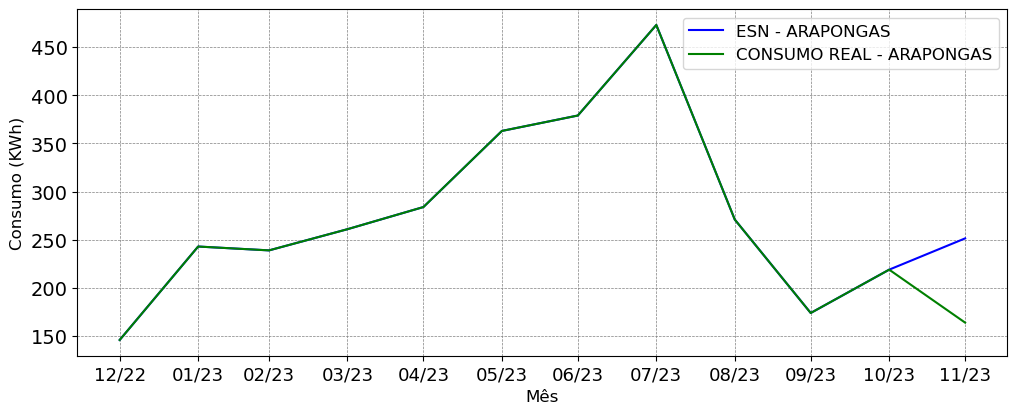

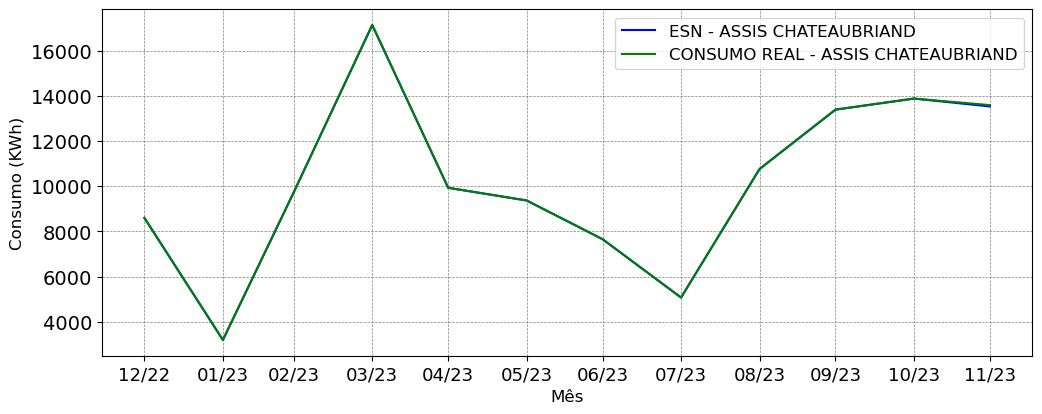

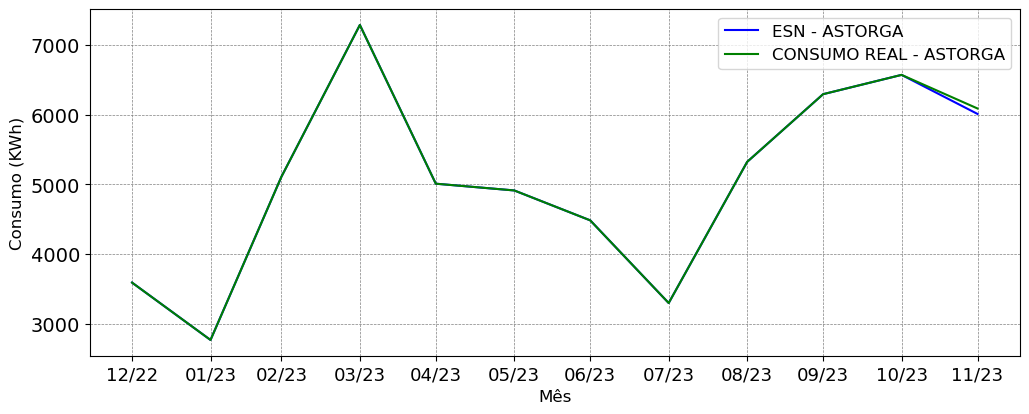

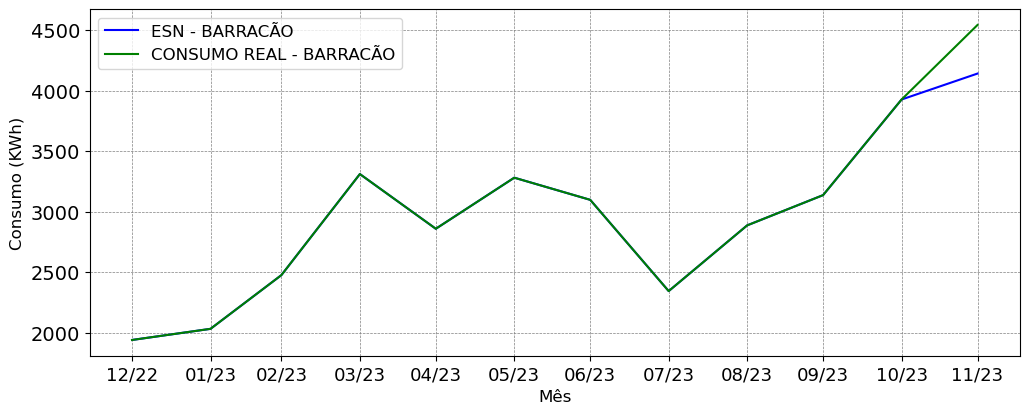

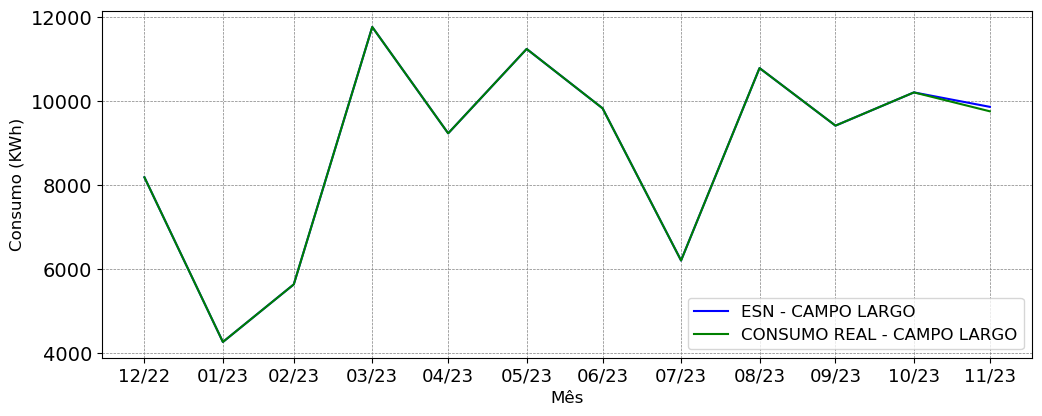

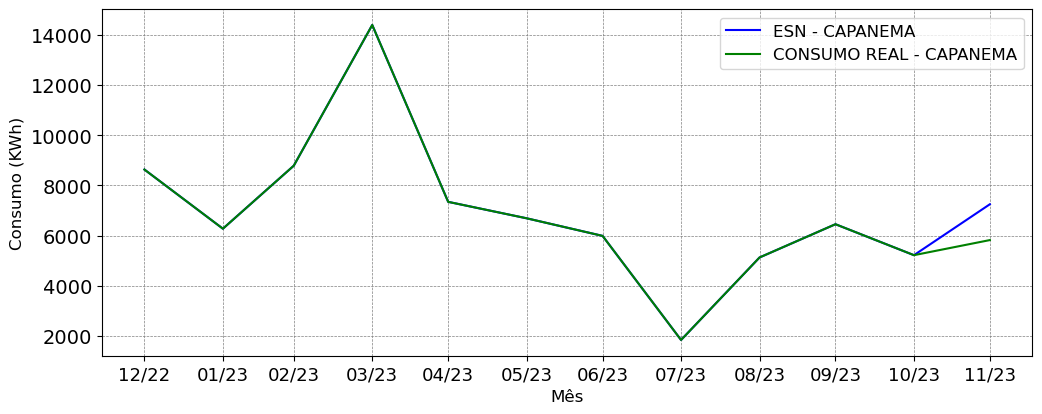

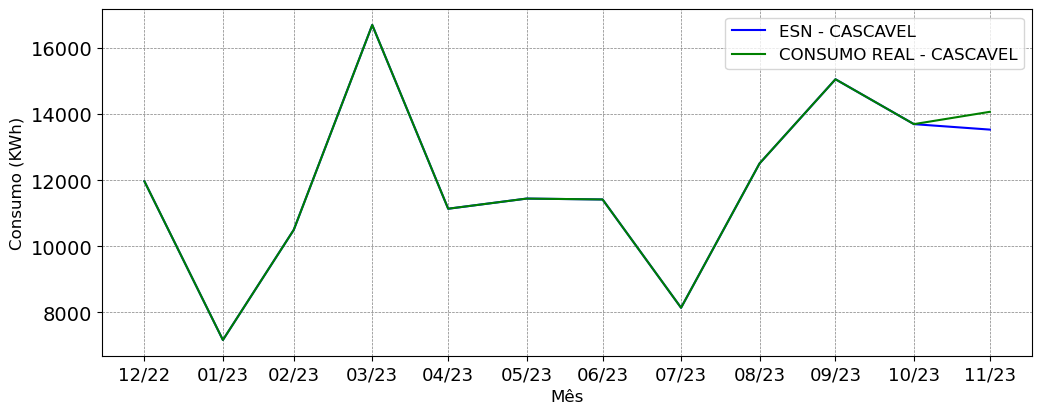

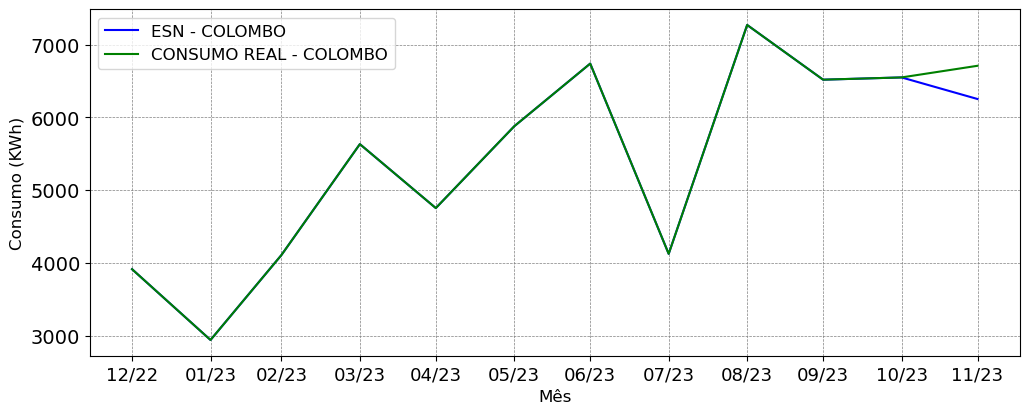

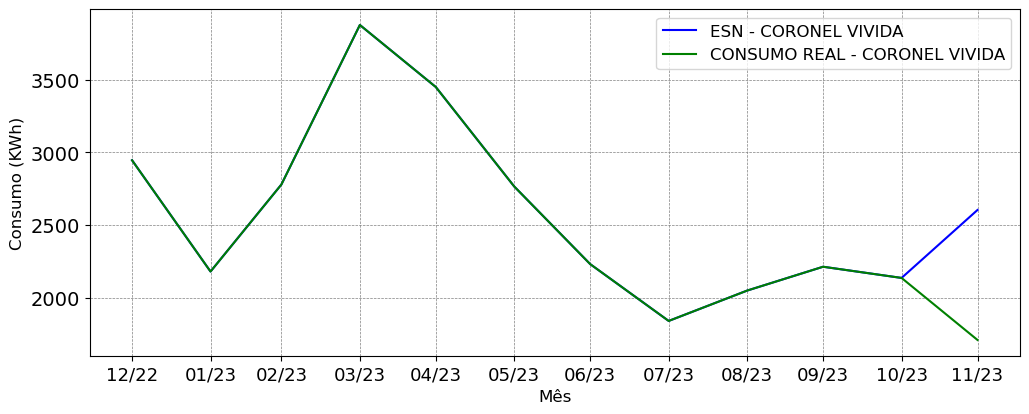

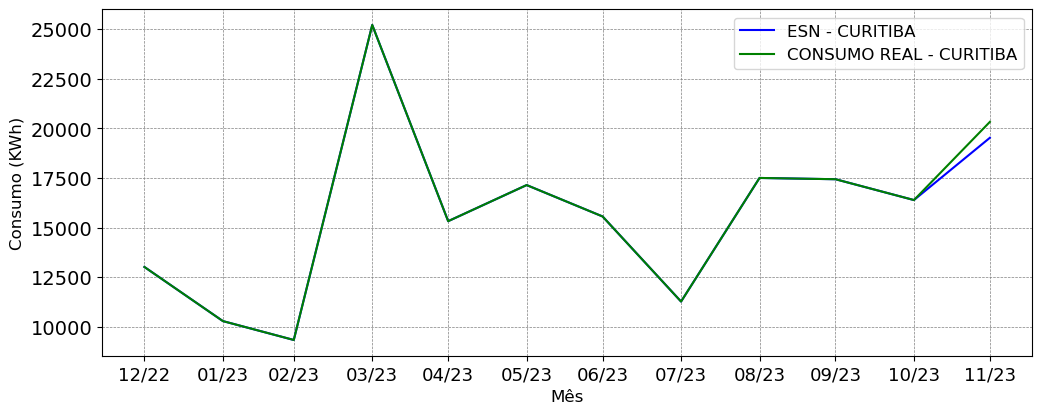

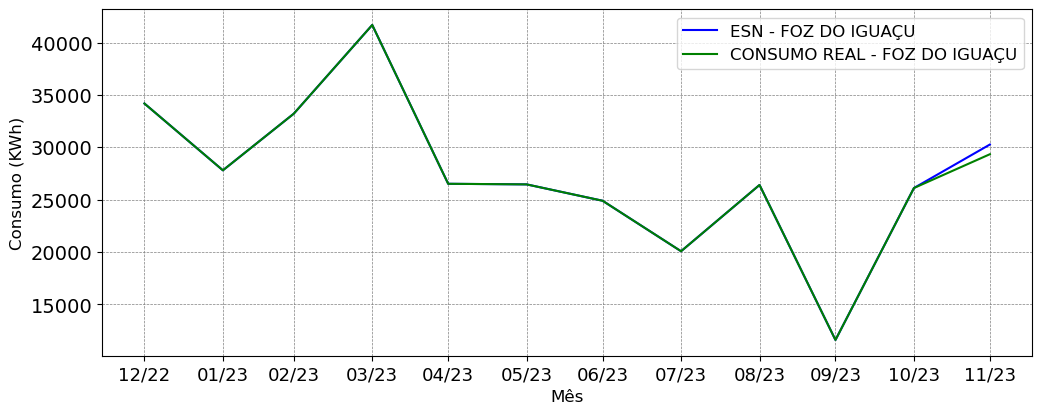

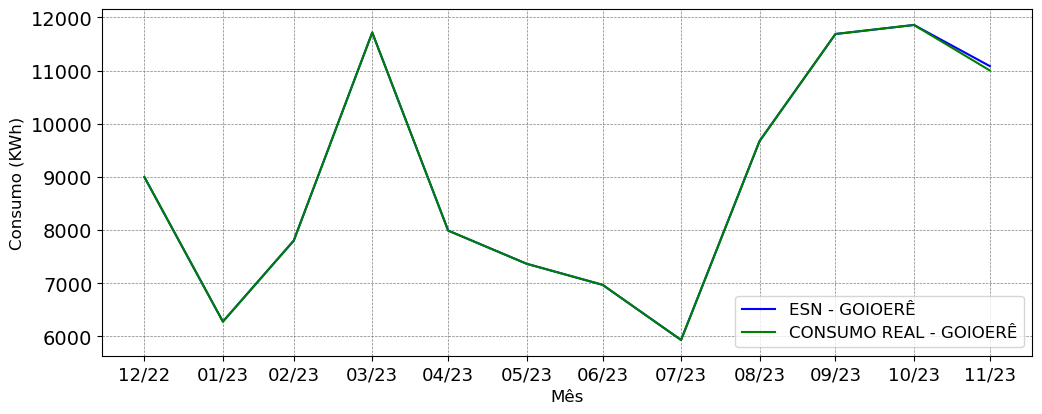

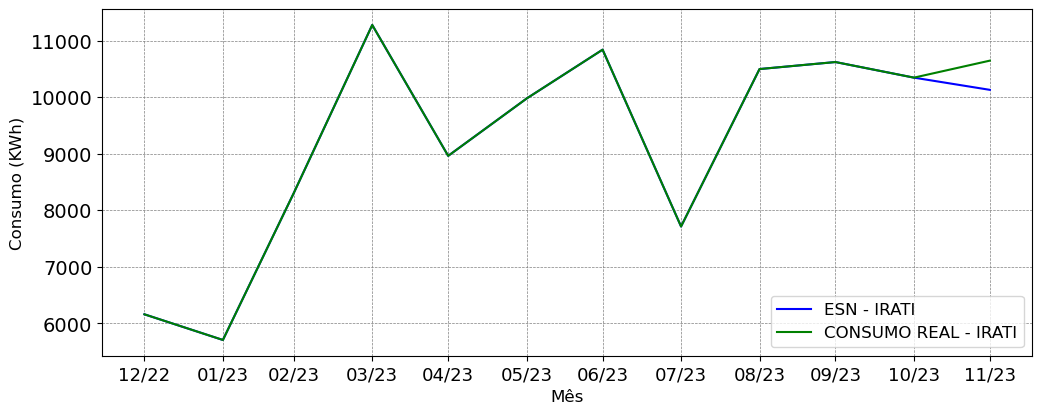

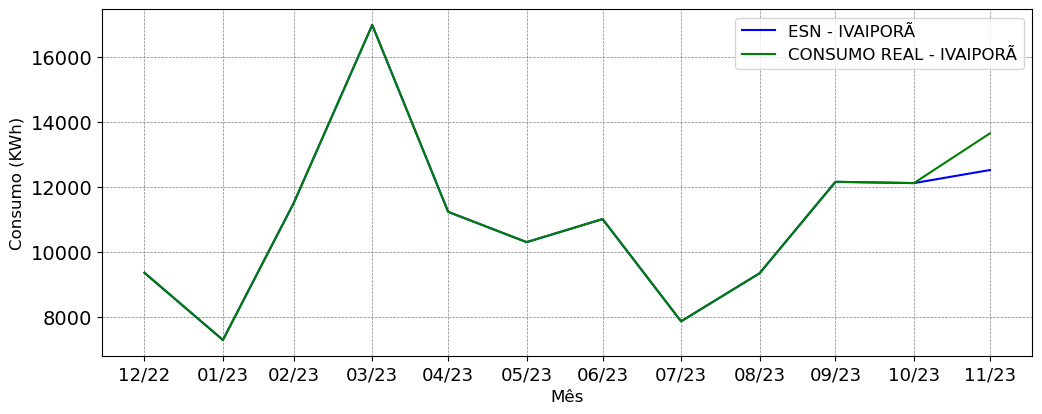

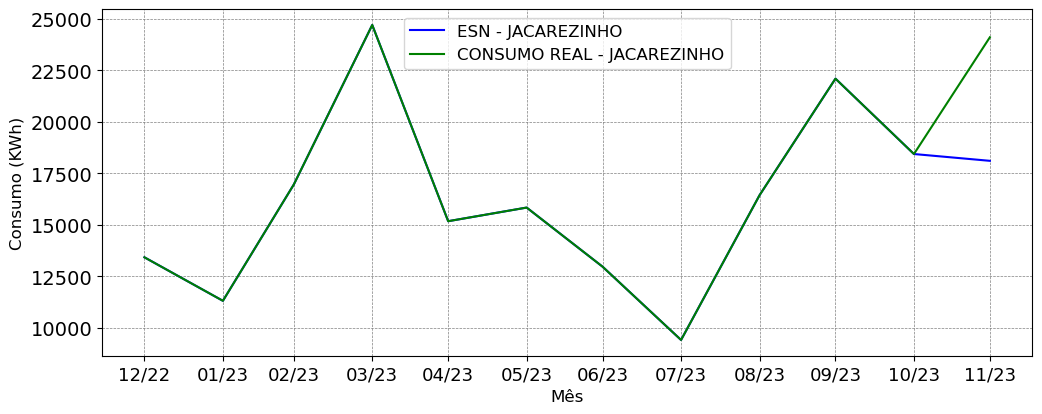

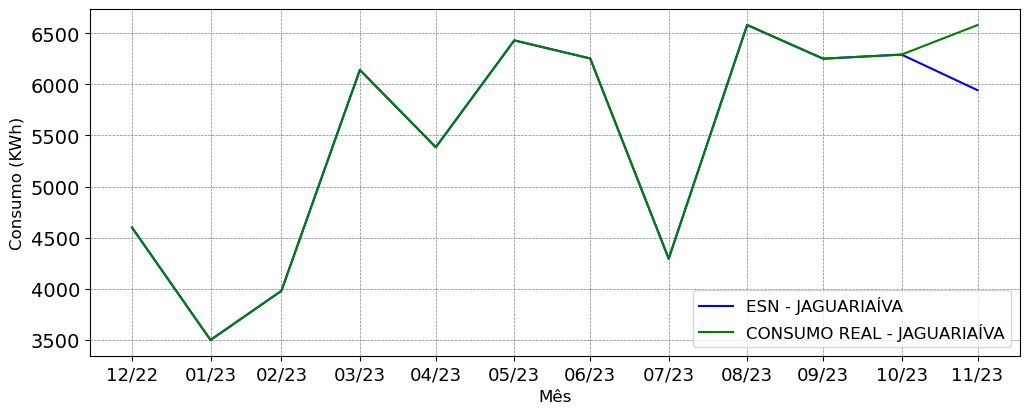

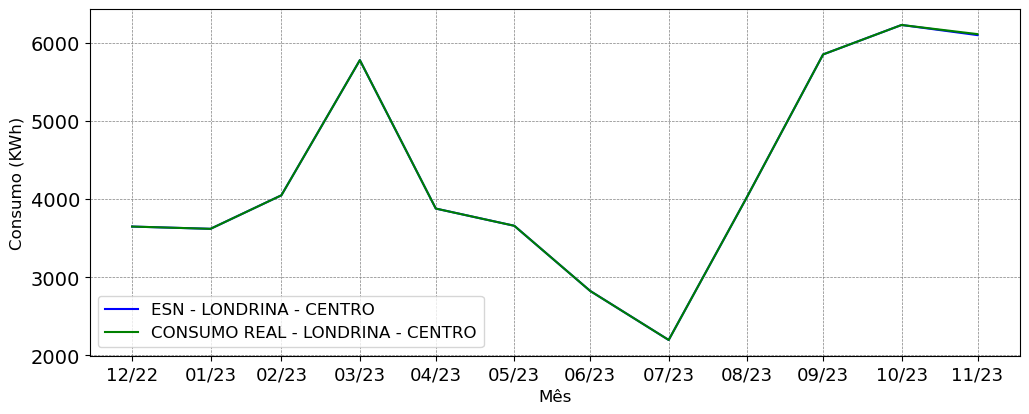

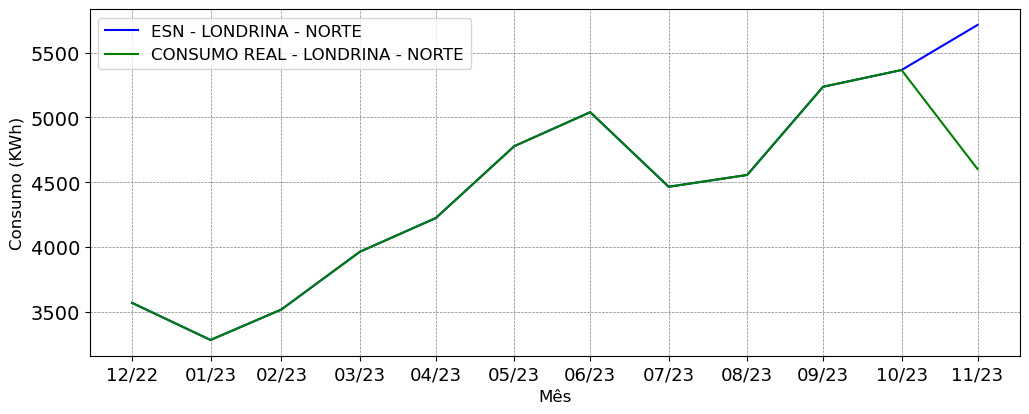

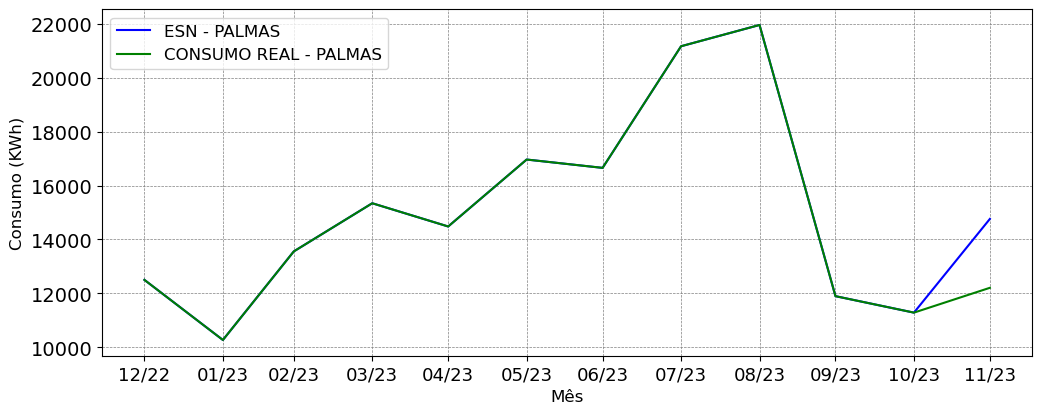

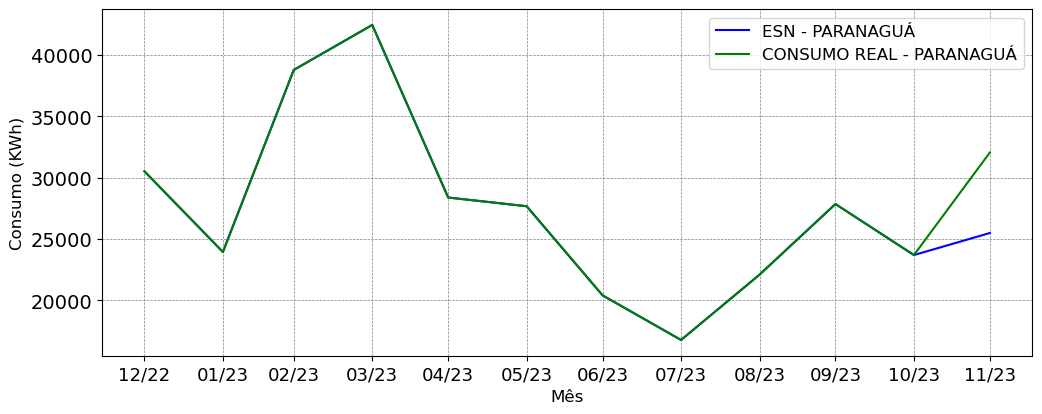

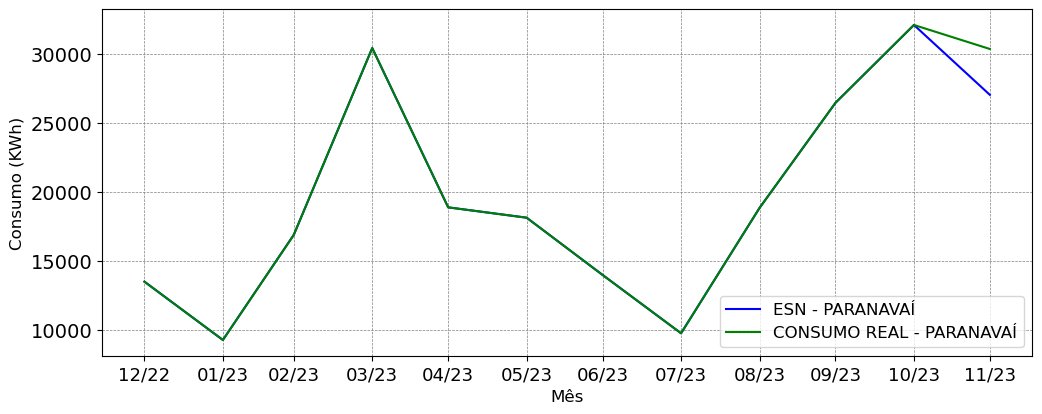

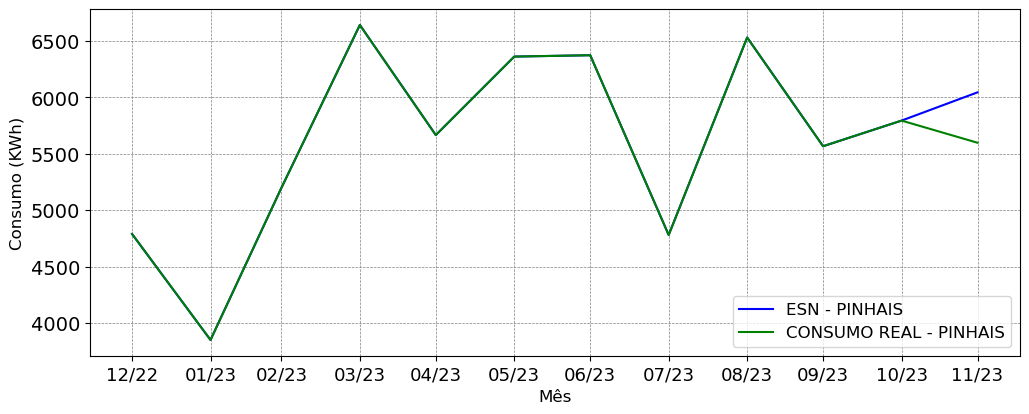

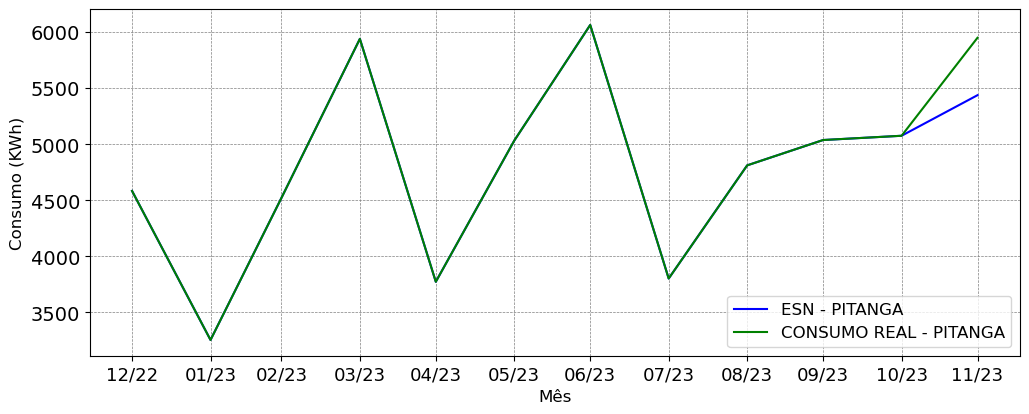

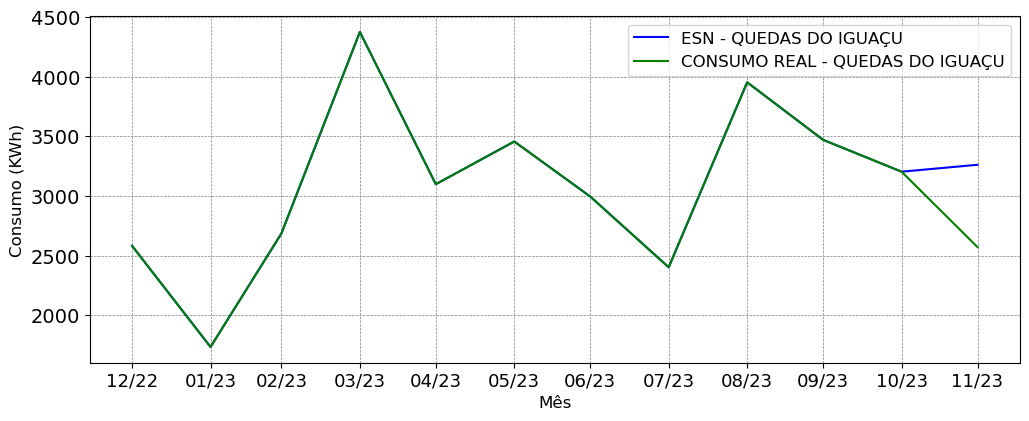

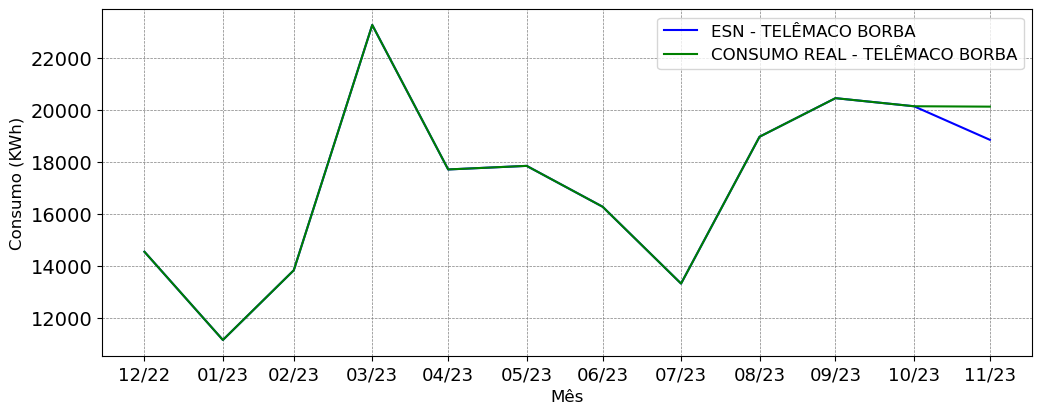

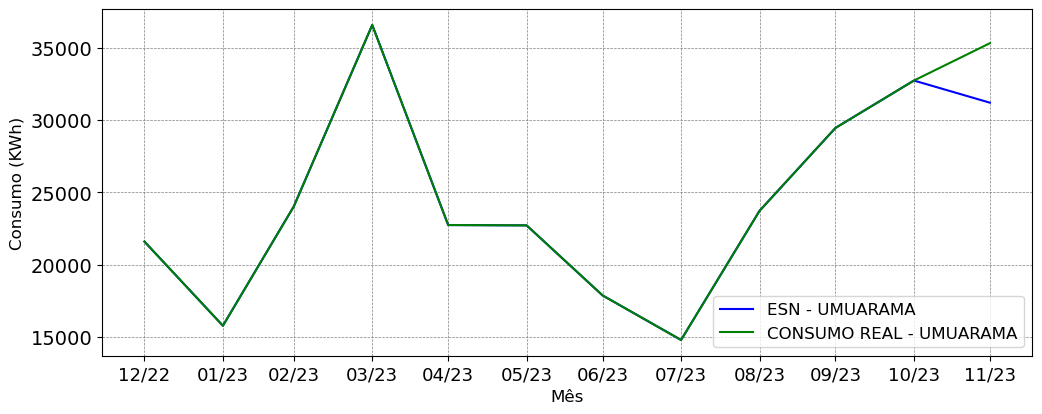

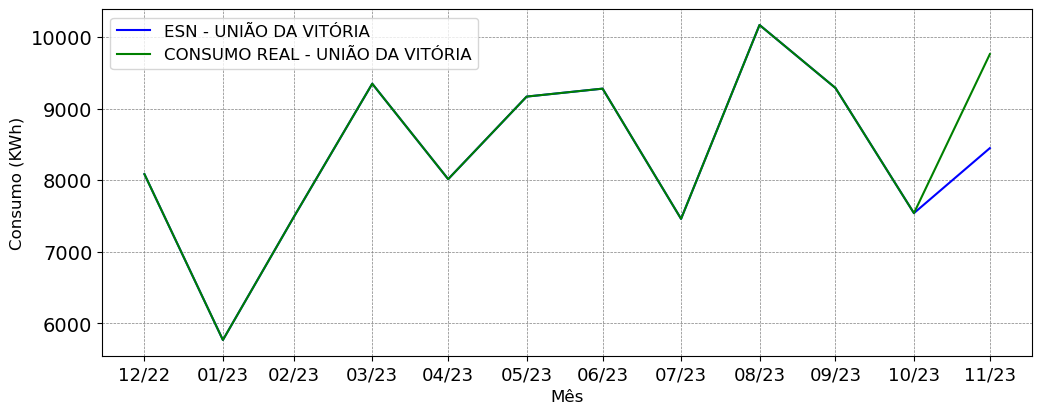

In [10]:
for campus, dado_real in df_mesclado.groupby("CAMPUS"):
    valores_previstos = {}
    dado_real["DATA"] = pandas.to_datetime(dado_real["DATA"])
    dado_real = dado_real.set_index("DATA")
    scaler = scalers[campus]

    for nome_modelo in modelos:
        dados = dataframes_todos[(campus, nome_modelo)].to_pandas()
        dados.index = pandas.to_datetime(dados.index)
        colunas = dados[features].drop(dados.filter(like='LAG_').columns.tolist(), axis=1).columns
        colunas = np.append('CONSUMO', colunas)

        dados[colunas] = scaler.inverse_transform(dados[colunas]).round(2)
        valores_previstos[nome_modelo] = dados

    dado_real = dado_real[12:len(valores_previstos[modelos[0]])+12]

    plt = ts_comparacao(campus, dado_real, valores_previstos)
    plt.savefig(f"resultados/previsoes - treino conjunto/Previsao {horizonte}M {campus}.png", bbox_inches='tight')



## Treino com campi individuais

/tmp/ipykernel_97947/4037423294.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4.5))


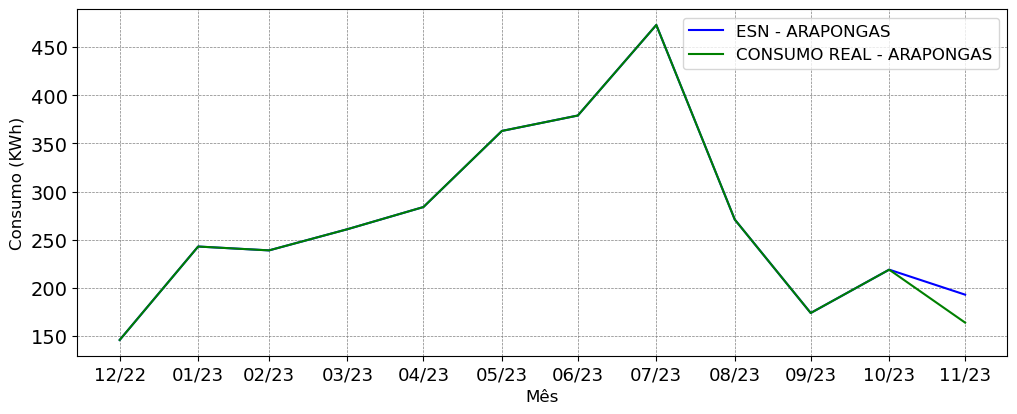

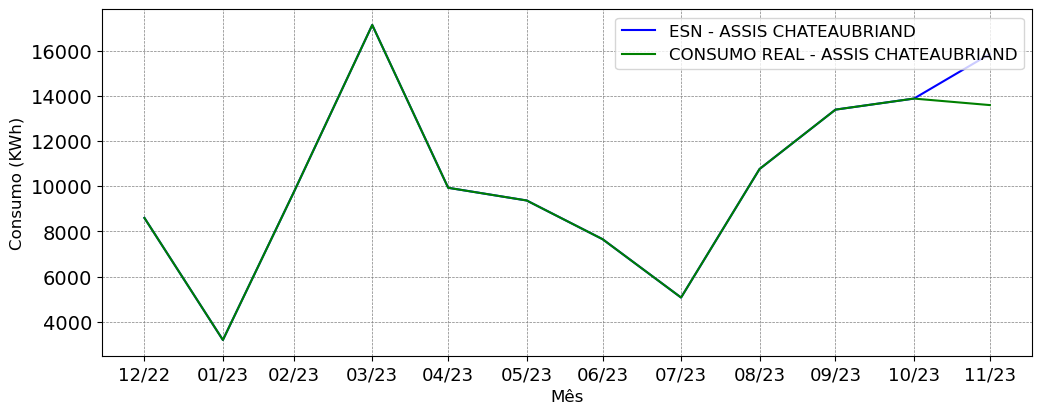

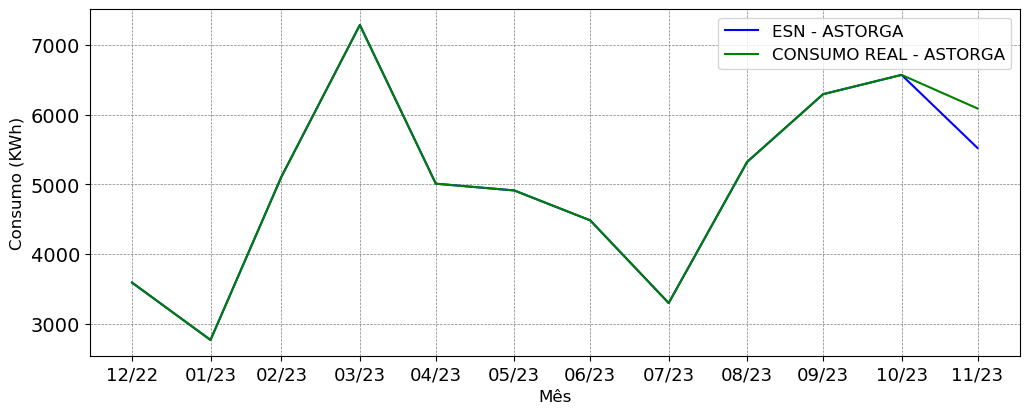

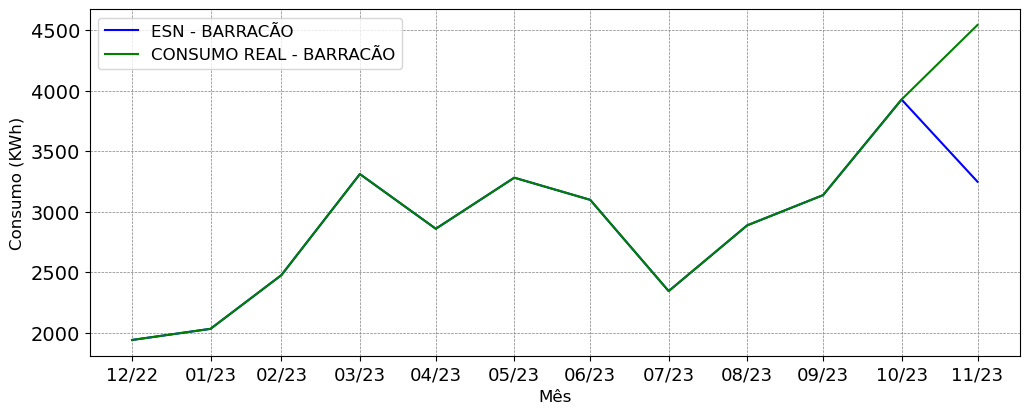

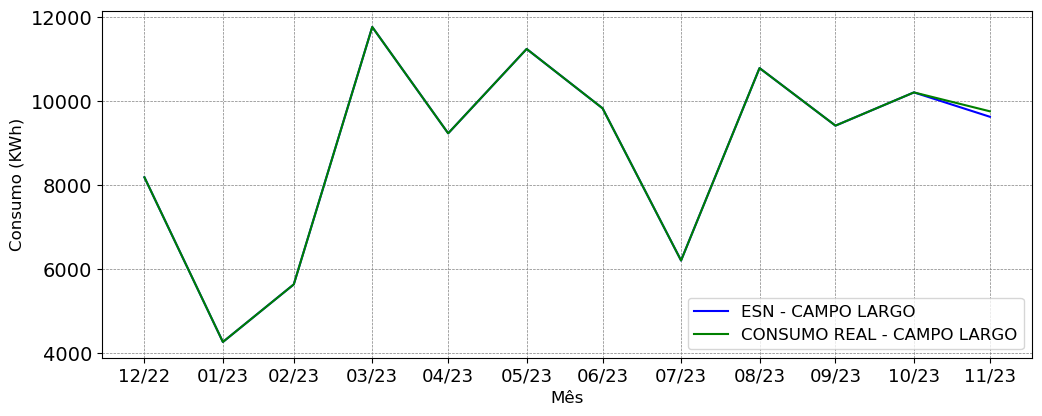

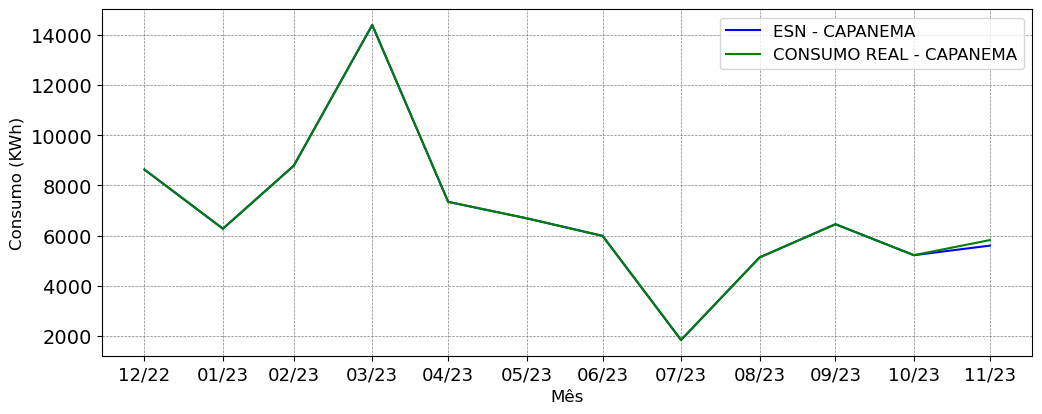

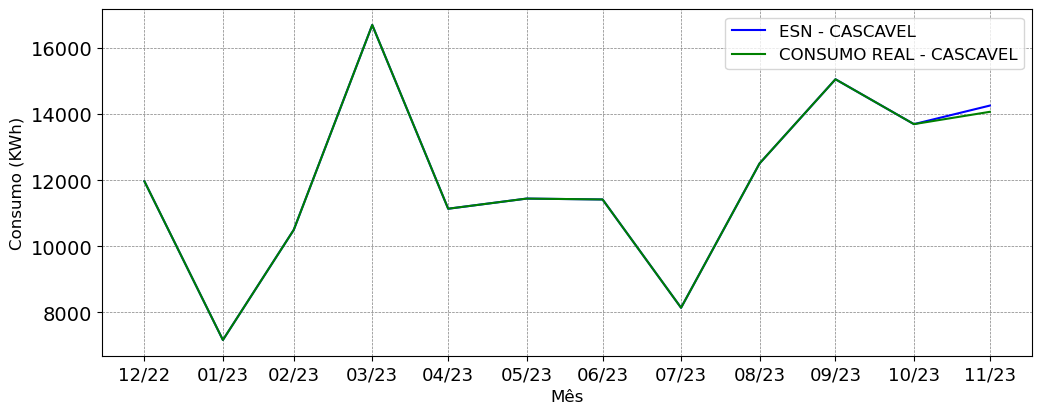

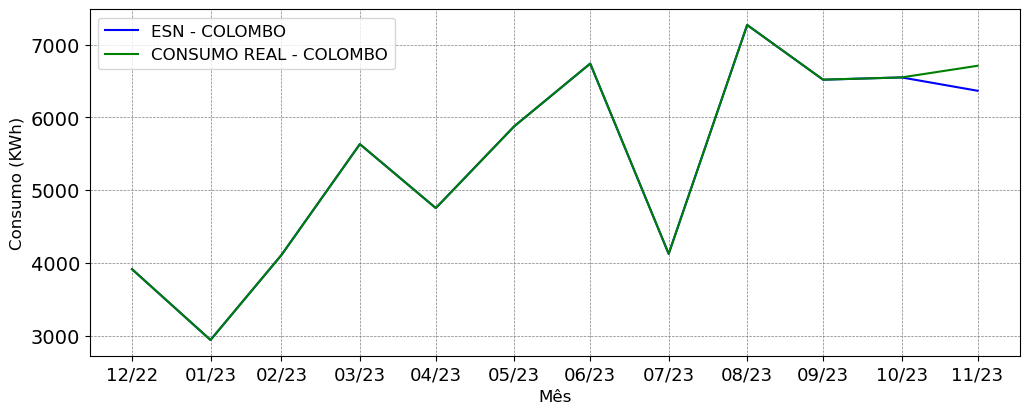

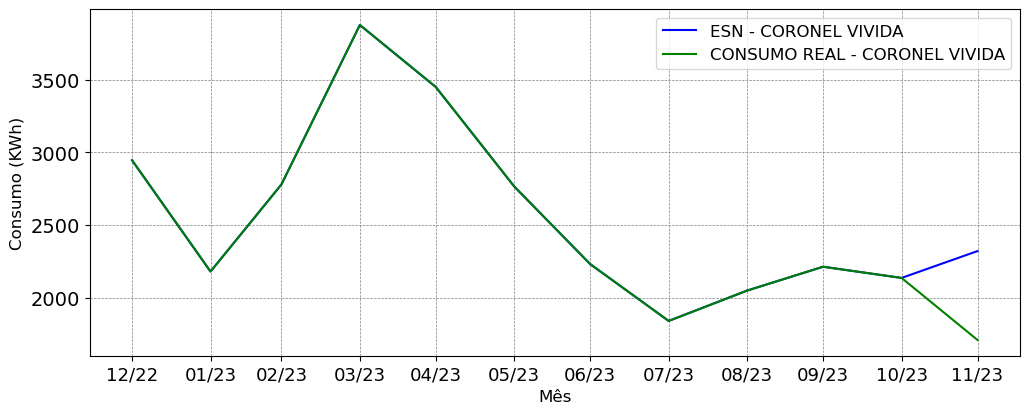

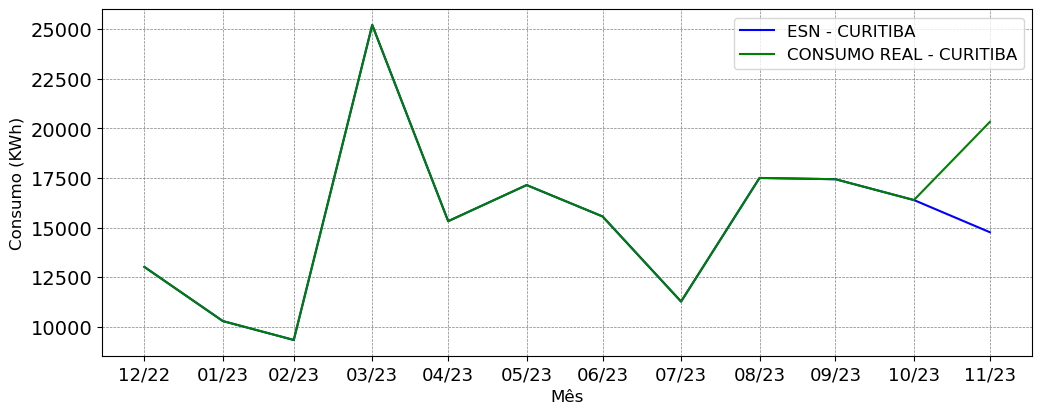

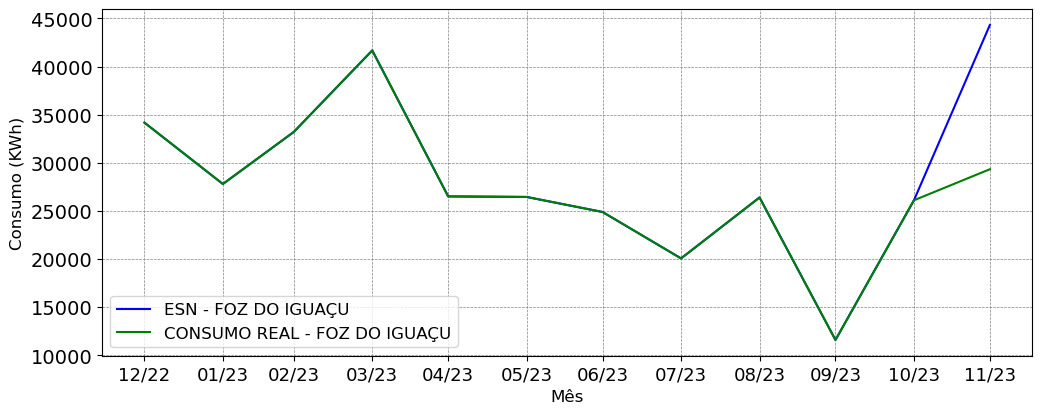

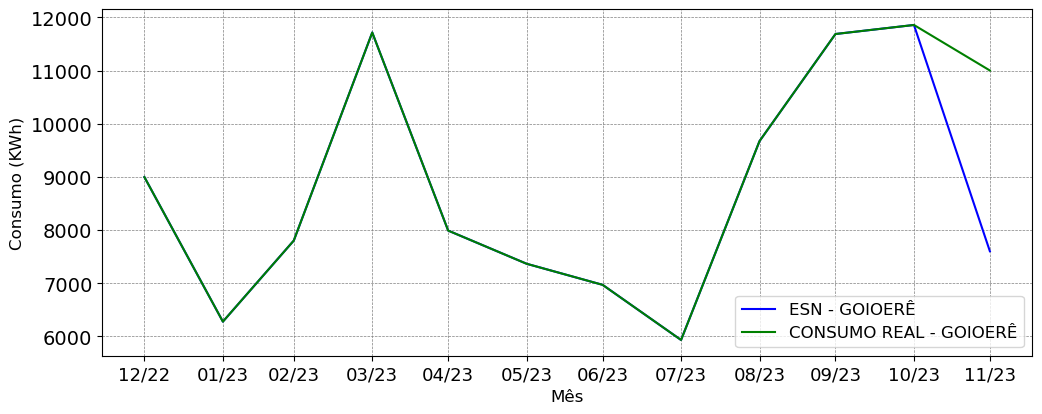

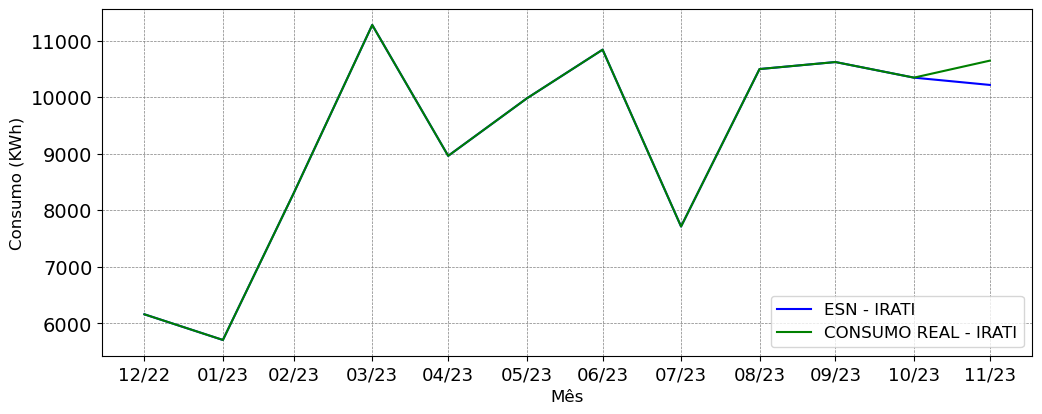

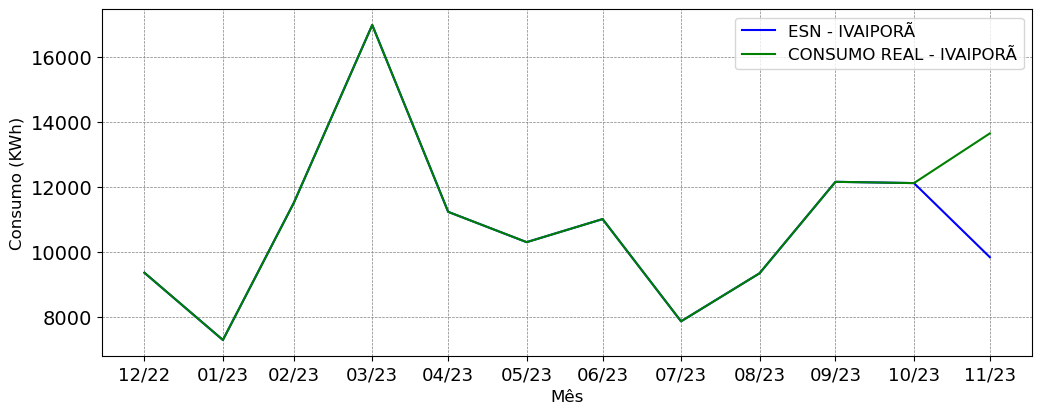

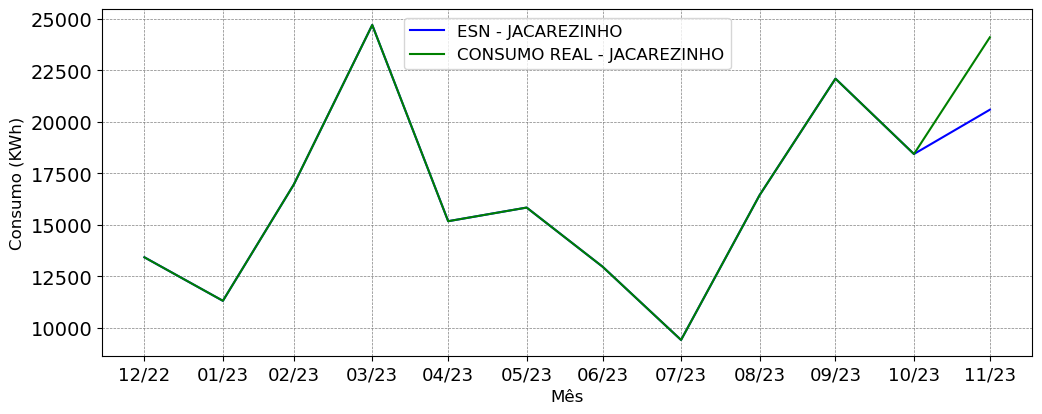

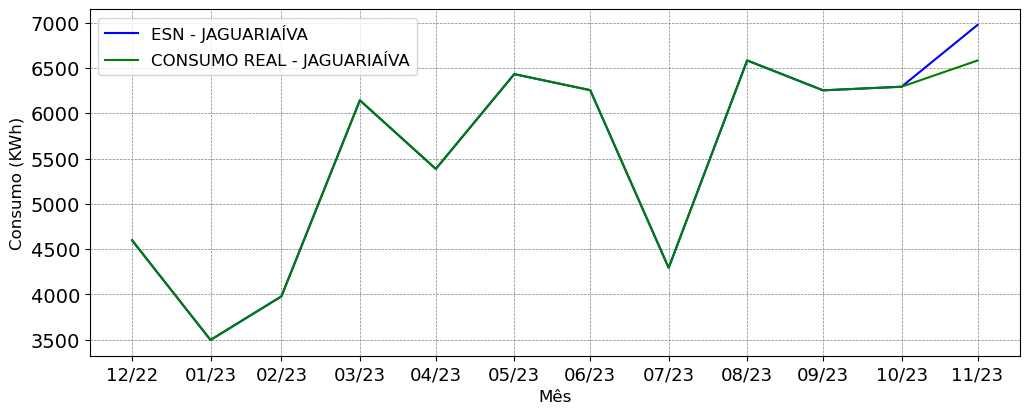

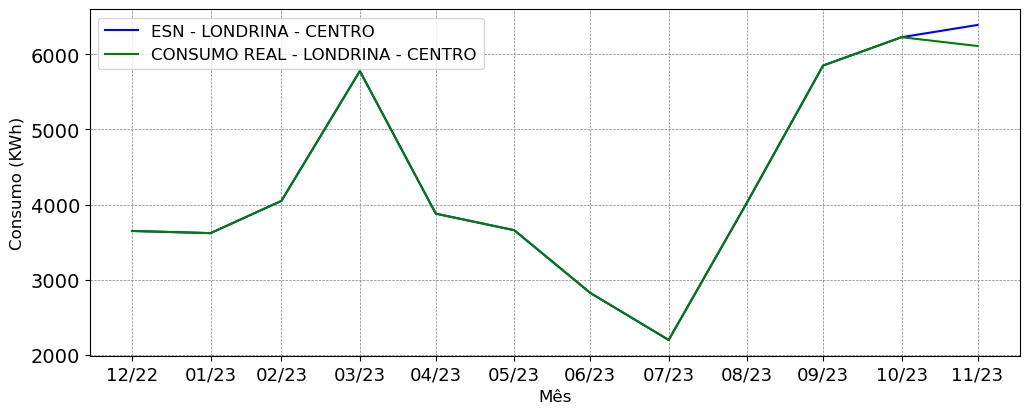

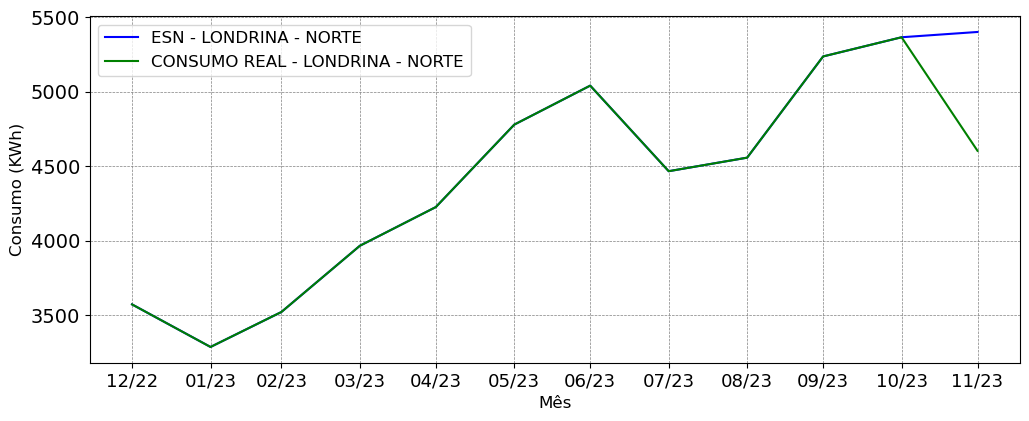

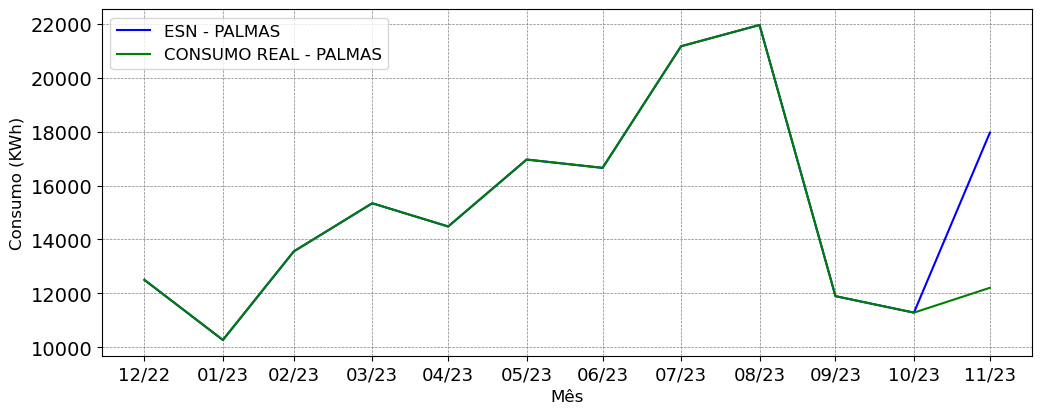

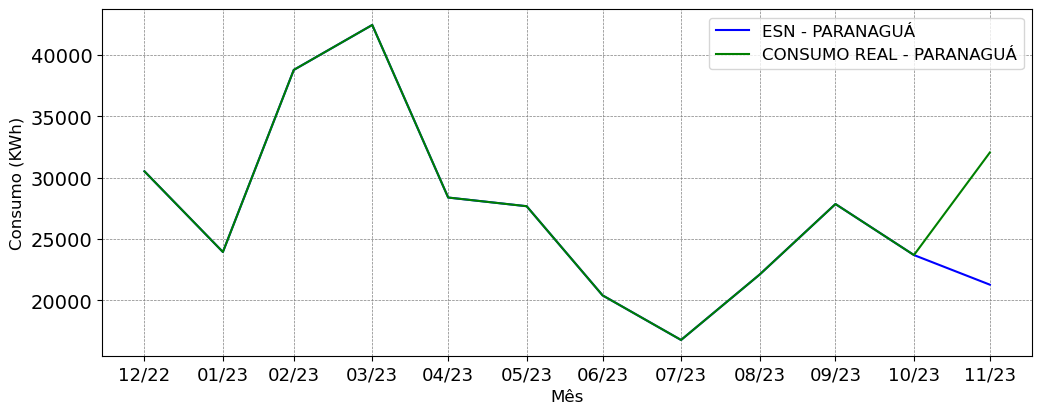

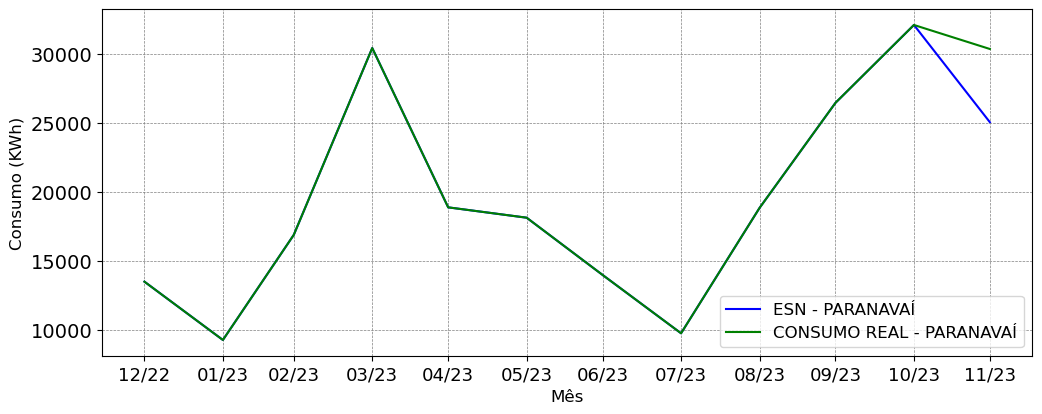

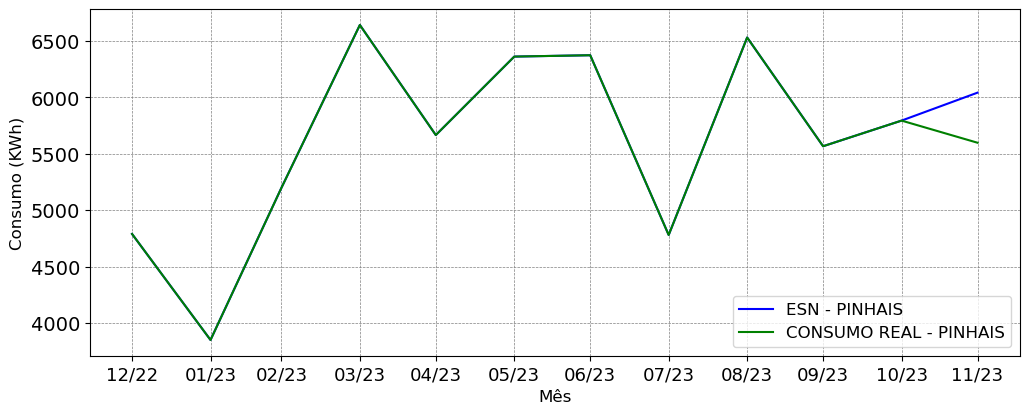

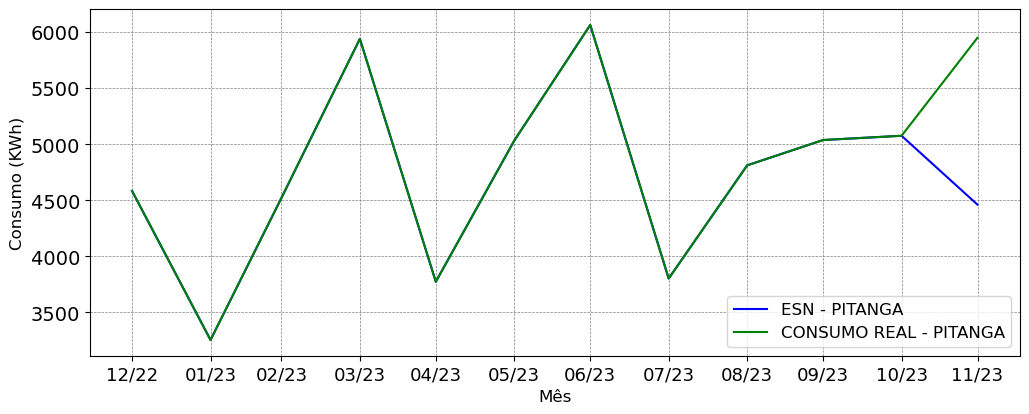

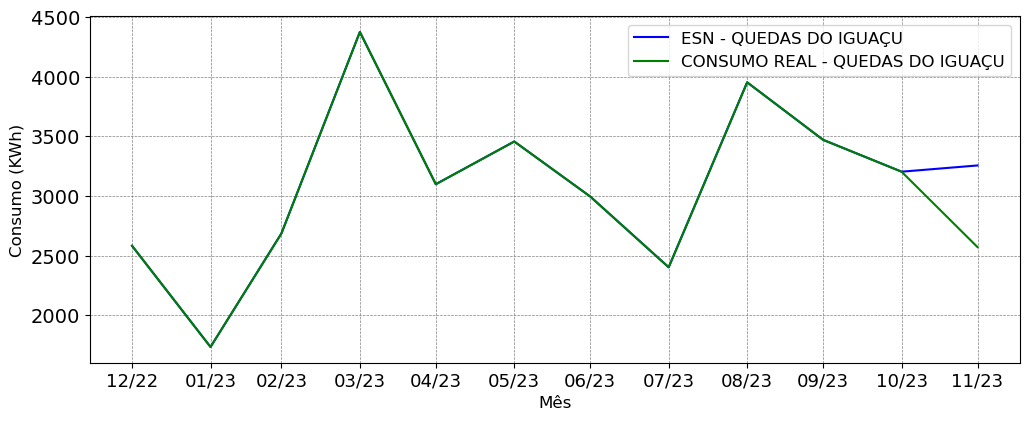

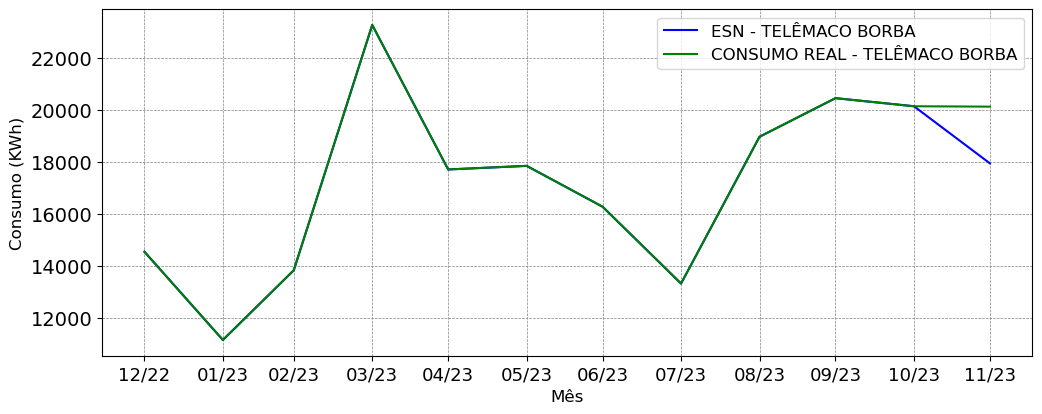

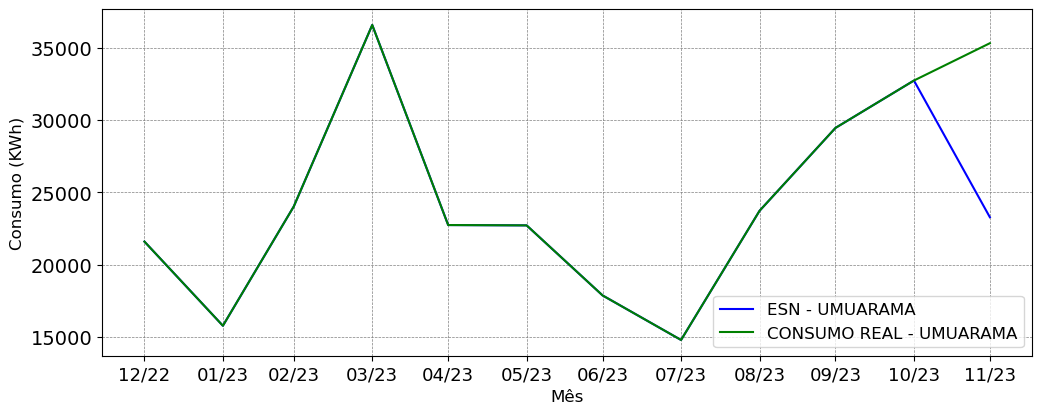

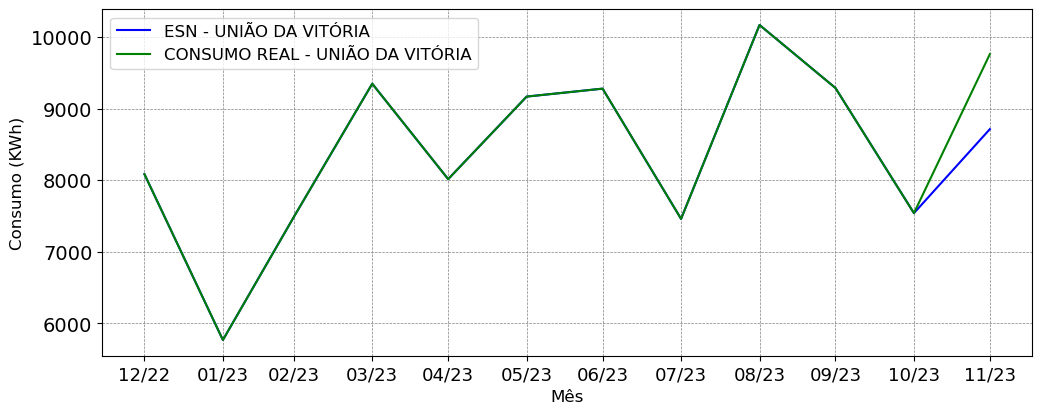

In [11]:
for campus, dado_real in df_mesclado.groupby("CAMPUS"):
    valores_previstos = {}
    dado_real["DATA"] = pandas.to_datetime(dado_real["DATA"])
    dado_real = dado_real.set_index("DATA")
    scaler = scalers[campus]

    for nome_modelo in modelos:
        dados = dataframes_ind[(campus, nome_modelo)].to_pandas()
        dados.index = pandas.to_datetime(dados.index)
        colunas = dados[features].drop(dados.filter(like='LAG_').columns.tolist(), axis=1).columns
        colunas = np.append('CONSUMO', colunas)

        dados[colunas] = scaler.inverse_transform(dados[colunas]).round(2)
        valores_previstos[nome_modelo] = dados

    dado_real = dado_real[12:len(valores_previstos[modelos[0]])+12]

    plt = ts_comparacao(campus, dado_real, valores_previstos)
    plt.savefig(f"resultados/previsoes - treino individual/Previsao {horizonte}M {campus}.png", bbox_inches='tight')



In [12]:
dados

TEMP_MÉD_MÉD_MENS  TEMP_MÉD_MAX_MENS  TEMP_MÉD_ACC_MENS  \
DATA                                                                  
2018-10-31               18.0               22.0              565.0   
2018-11-30               21.0               26.0              621.0   
2018-12-31               24.0               27.0              729.0   
2019-01-31               24.0               26.0              758.0   
2019-02-28               22.0               26.0              619.0   
...                       ...                ...                ...   
2023-07-31               14.0               19.0              441.0   
2023-08-31               15.0               23.0              478.0   
2023-09-30               19.0               25.0              572.0   
2023-10-31               19.0               23.0              590.0   
2023-11-30               21.0               27.0              633.0   

            TEMP_MIN_MIN_MENS  TEMP_MIN_MAX_MENS  TEMP_MIN_ACC_MENS  \
DATA                                                                  
2018-10-31                9.0               17.0              434.0   
2018-11-30               10.0               20.0              451.0   
2018-12-31                9.0               21.0              513.0   
2019-01-31               16.0               21.0              576.0   
2019-02-28               15.0               20.0              477.0   
...                       ...                ...                ...   
2023-07-31                3.0               14.0              292.0   
2023-08-31                2.0               17.0              299.0   
2023-09-30                5.0               19.0              402.0   
2023-10-31               10.0               19.0              456.0   
2023-11-30                6.0               21.0              479.0   

            TEMP_MAX_MAX_MENS  TEMP_MAX_ACC_MENS  PRECIPITAÇÃO_MAX_MENS  \
DATA                                                                      
2018-10-31               29.0              697.0                   36.0   
2018-11-30               31.0              791.0                   13.0   
2018-12-31               34.0              945.0                   23.0   
2019-01-31               34.0              939.0                   16.0   
2019-02-28               34.0              760.0                   31.0   
...                       ...                ...                    ...   
2023-07-31               24.0              589.0                   89.0   
2023-08-31               30.0              656.0                   68.0   
2023-09-30               33.0              742.0                   52.0   
2023-10-31               30.0              724.0                  110.0   
2023-11-30               34.0              786.0                   51.0   

            DIA_DA_SEMANA_dom  ...    LAG_03    LAG_05    LAG_06    LAG_07  \
DATA                           ...                                           
2018-10-31                4.0  ...       NaN       NaN       NaN       NaN   
2018-11-30                4.0  ...       NaN       NaN       NaN       NaN   
2018-12-31                5.0  ...       NaN       NaN       NaN       NaN   
2019-01-31                4.0  ...  0.253418       NaN       NaN       NaN   
2019-02-28                4.0  ...  0.235082       NaN       NaN       NaN   
...                       ...  ...       ...       ...       ...       ...   
2023-07-31                5.0  ...  0.610387  0.554213  0.372125  0.617806   
2023-08-31                4.0  ...  0.732697  0.751775  0.554213  0.372125   
2023-09-30                4.0  ...  0.744462  0.610387  0.751775  0.554213   
2023-10-31                5.0  ...  0.551563  0.732697  0.610387  0.751775   
2023-11-30                4.0  ...  0.838792  0.744462  0.732697  0.610387   

              LAG_08    LAG_09    LAG_10    LAG_11    LAG_12       CONSUMO  
DATA                                                                        
2018-10-31       Na

In [13]:
dado_real

CONSUMO  TEMP_MIN_MÉD_MENS  TEMP_MÉD_MIN_MENS  TEMP_MÉD_MÉD_MENS  \
DATA                                                                           
2018-10-31   4646.0                9.0               13.0               18.0   
2018-11-30   4473.0               10.0               16.0               21.0   
2018-12-31   3792.0                9.0               18.0               24.0   
2019-01-31   3178.0               16.0               22.0               24.0   
2019-02-28   3753.0               15.0               18.0               22.0   
...             ...                ...                ...                ...   
2023-07-31   7459.0                3.0                8.0               14.0   
2023-08-31  10169.0                2.0                9.0               15.0   
2023-09-30   9288.0                5.0               13.0               19.0   
2023-10-31   7539.0               10.0               13.0               19.0   
2023-11-30   9762.0                6.0               15.0               21.0   

            TEMP_MÉD_MAX_MENS  TEMP_MÉD_ACC_MENS  TEMP_MAX_MÉD_MENS  \
DATA                                                                  
2018-10-31               22.0              565.0               29.0   
2018-11-30               26.0              621.0               31.0   
2018-12-31               27.0              729.0               34.0   
2019-01-31               26.0              758.0               34.0   
2019-02-28               26.0              619.0               34.0   
...                       ...                ...                ...   
2023-07-31               19.0              441.0               24.0   
2023-08-31               23.0              478.0               30.0   
2023-09-30               25.0              572.0               33.0   
2023-10-31               23.0              590.0               30.0   
2023-11-30               27.0              633.0               34.0   

            PRECIPITAÇÃO_MÉD_MENS  TEMP_MIN_MIN_MENS  TEMP_MIN_MAX_MENS  ...  \
DATA                                                                     ...   
2018-10-31                    6.0                9.0               17.0  ...   
2018-11-30                    1.0               10.0               20.0  ...   
2018-12-31                    3.0                9.0               21.0  ...   
2019-01-31                    4.0               16.0               21.0  ...   
2019-02-28                    5.0               15.0               20.0  ...   
...                           ...                ...                ...  ...   
2023-07-31                    6.0                3.0               14.0  ...   
2023-08-31                    6.0                2.0               17.0  ...   
2023-09-30                    6.0                5.0               19.0  ...   
2023-10-31                   18.0               10.0               19.0  ...   
2023-11-30                    9.0                6.0               21.0  ...   

            CURSOS_GRAD_VESPERTINO  CURSOS_GRAD_NOTURNO  CURSOS_POS  FÉRIAS  \
DATA                                                                          
2018-10-31                     0.0             0.000000         0.0       0   
2018-11-30                     0.0             0.000000         0.0       0   
2018-12-31                     0.0             0.000000         0.0       0   
2019-01-31                     0.0             0.000000         0.0      31   
2019-02-28                     0.0             0.821429         0.0       0   
...                            ...                  ...         ...     ...   
2023-07-31                     1.0             1.000000         0.0      15   
2023-08-31                     1.0             1.000000         0.0       0   
2023-09-30                     1.0             1.000000         0.0       0   
2023-10-31                     1.0             1.000000         0.0       0   
2023-11-30                     1.0             1.000000   